Import packages and set paths

In [1]:
import os
import sys
import emc2
import pint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib as mpl
import pandas as pd
import numpy as np
import xarray as xr
import pyreadr
from matplotlib.colors import LinearSegmentedColormap
ureg = pint.UnitRegistry()

# Navigate to the ACCESS-AM2 data directory
os.chdir('/g/data/jk72/slf563/ACCESS/output/cc407/hourly')
# Check current project directory
print("Project directory:", os.getcwd())

Project directory: /g/data/jk72/slf563/ACCESS/output/cc407/hourly


In [2]:
# Load the model data

# Set the model output path
# model_output = 'cc407a.ph.met20180219.nc'
model_output = 'cc407a.ph.met20180201.nc'

# Load data
met20180219 = xr.open_dataset(model_output)

In [3]:
# Load MARCUS coordinate data

# Load MARCUS coordinate data and reformat as datetime62
marcus_coordinates_v1_3 = pd.read_csv('/g/data/jk72/ck4840/projects/emc2/data/marcus_coordinates/marcus_coordinates_v1_3.csv')
marcus_coordinates_v1_3['datetime_day'] = pd.to_datetime(marcus_coordinates_v1_3['datetime_day'])

# Extract the date from the 'time' coordinate in the model data and filter the MARCUS coordinate data to the model data date
marcus_coordinates = marcus_coordinates_v1_3[marcus_coordinates_v1_3['datetime_day'].dt.date == pd.to_datetime(met20180219['time'].values).date[0]]

# Convert MARCUS coordinate data to XArray dataset and convert datetime_hour variable to a coordinate
marcus_coordinates = xr.Dataset.from_dataframe(marcus_coordinates)
marcus_coordinates = marcus_coordinates.set_coords(['datetime_hour'])

In [4]:
# Subset the met20180219 model data to the Underway coordinates

# Ensure that the time coordinates are the same data type
marcus_coordinates['datetime_hour'] = marcus_coordinates['datetime_hour'].astype('datetime64[ns]')
met20180219['time'] = met20180219['time'].astype('datetime64[ns]')

# Extract the time values from the ACCESS model data
time_values = met20180219['time'].values

In [5]:
# print(met20180219)

In [6]:
# print(marcus_coordinates)

In [7]:
# Initalise list to store the individual datasets from each iteration
list_of_datasets = []

# Loop over each time step in the ship dataset
for i in range(len(marcus_coordinates['datetime_hour'])):
    # Get the lat, lon, and time values for each step
    lat = marcus_coordinates['latitude'].isel(index=i)
    lon = marcus_coordinates['longitude'].isel(index=i)
    time = marcus_coordinates['datetime_hour'].isel(index=i)
    
    # Interpolating the entire dataset at the ship's position
    met20180219_interpolated = met20180219.interp(
        lat=lat.item(), 
        lon=lon.item(), 
        time=time_values[i], 
        method='nearest'
    )
    
    # Append each interpolated dataset to the list
    list_of_datasets.append(met20180219_interpolated)

# Concatenate all datasets along a new dimension 'index'
met20180219_subset = xr.concat(list_of_datasets, dim='index')

# Now, the combined_dataset contains the interpolated values for each time step in a single dataset

In [8]:
# Extract model variables for plotting

met_liquid_cloud_fraction = met20180219_subset['field267']
met_ice_cloud_fraction = met20180219_subset['field268']
met_ncl = met20180219_subset['field4210'].values
met_qcl = met20180219_subset['field254'].values
met_qpl = met20180219_subset['field394'].values
met_qci = met20180219_subset['field12'].values
met_qpi = met20180219_subset['field396'].values
met_qpg = met20180219_subset['field395'].values
met_qtot = met20180219_subset['field254'].values + met20180219_subset['field394'].values + met20180219_subset['field12'].values + met20180219_subset['field396'].values + met20180219_subset['field395'].values
met_height = met20180219_subset['z1_hybrid_height']
met_time = met20180219_subset['time']

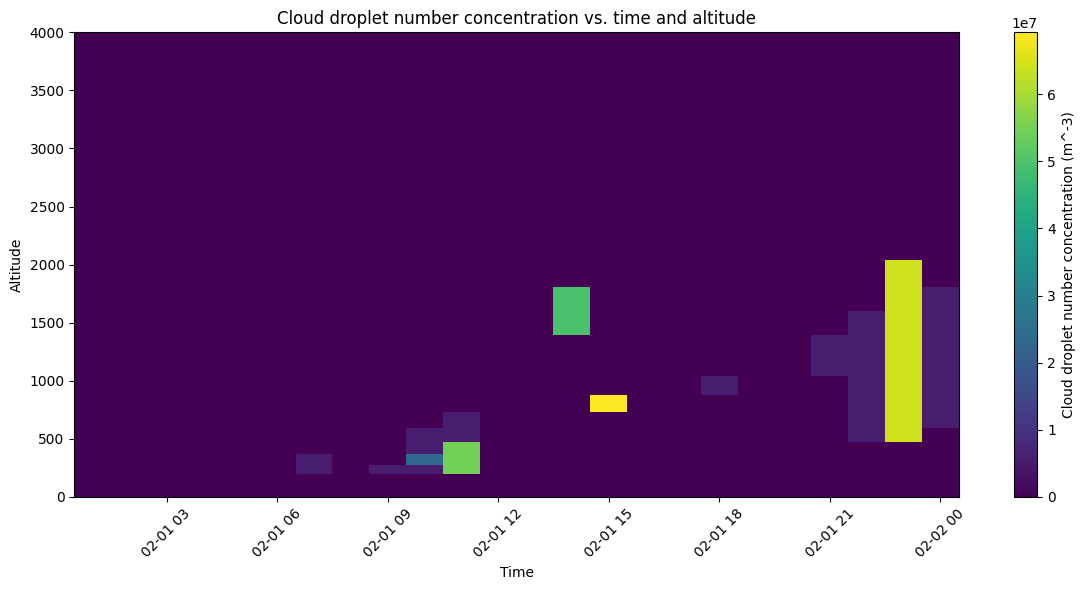

In [9]:
# Plot cloud droplet number concentration

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_ncl.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Cloud droplet number concentration (m^-3)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Cloud droplet number concentration vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_ncl_20180219 = plt.gcf()
# ACCESS_ncl_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_ncl_20180219.png', dpi=200)
plt.show()

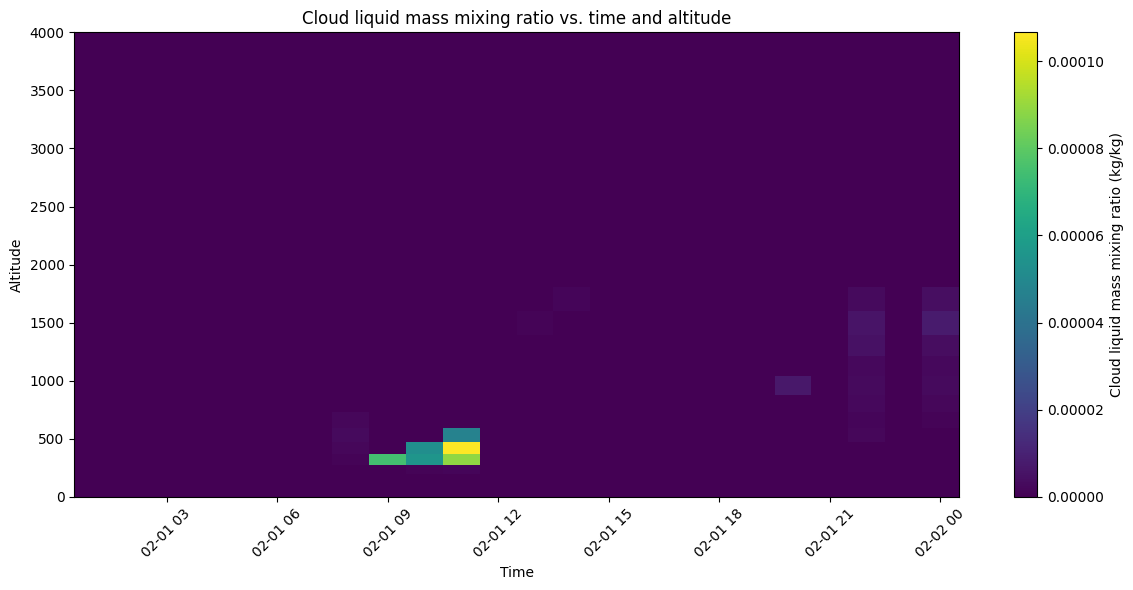

In [10]:
# Plot cloud liquid mass mixing ratio

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_qcl.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Cloud liquid mass mixing ratio (kg/kg)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Cloud liquid mass mixing ratio vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_qcl_20180219 = plt.gcf()
# ACCESS_qcl_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_qcl_20180219.png', dpi=200)
plt.show()

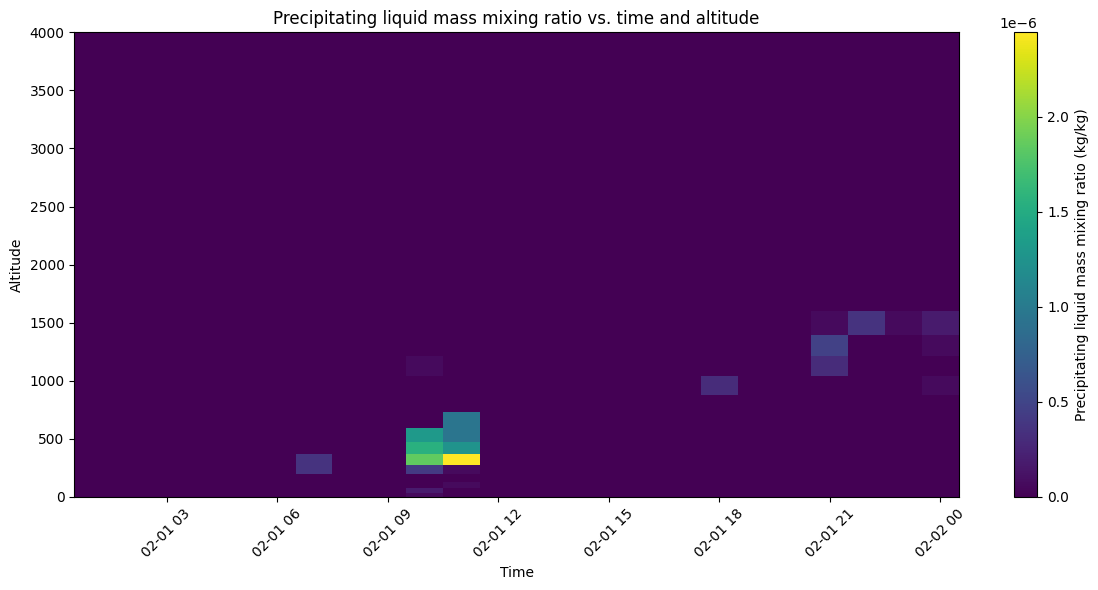

In [11]:
# Plot precipitating liquid mass mixing ratio

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_qpl.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Precipitating liquid mass mixing ratio (kg/kg)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Precipitating liquid mass mixing ratio vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_qpl_20180219 = plt.gcf()
# ACCESS_qpl_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_qpl_20180219.png', dpi=200)
plt.show()

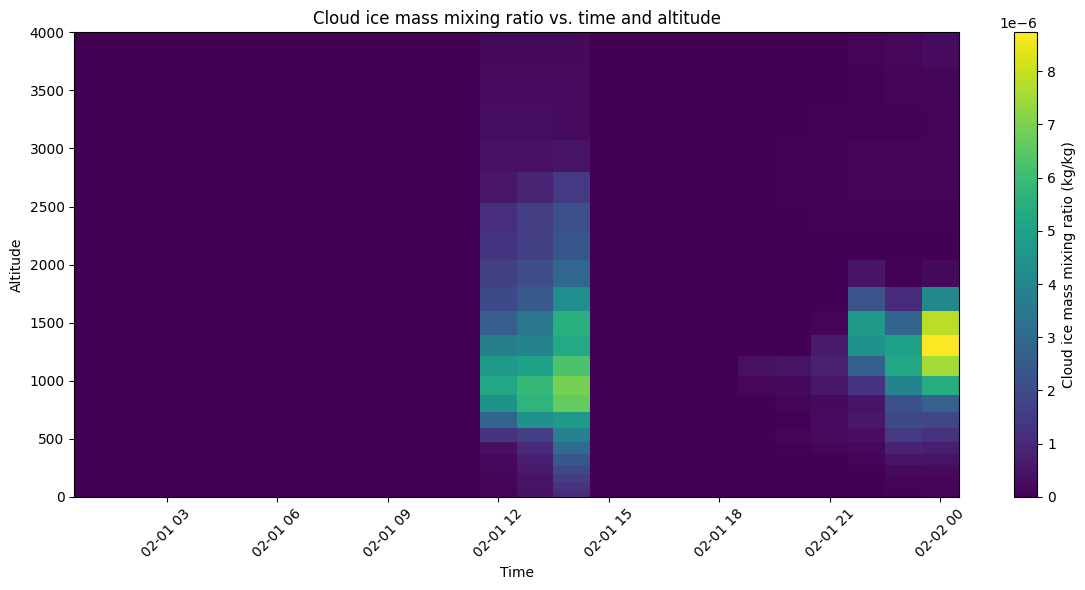

In [12]:
# Plot cloud ice mass mixing ratio

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_qci.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Cloud ice mass mixing ratio (kg/kg)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Cloud ice mass mixing ratio vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_qci_20180219 = plt.gcf()
# ACCESS_qci_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_qci_20180219.png', dpi=200)
plt.show()

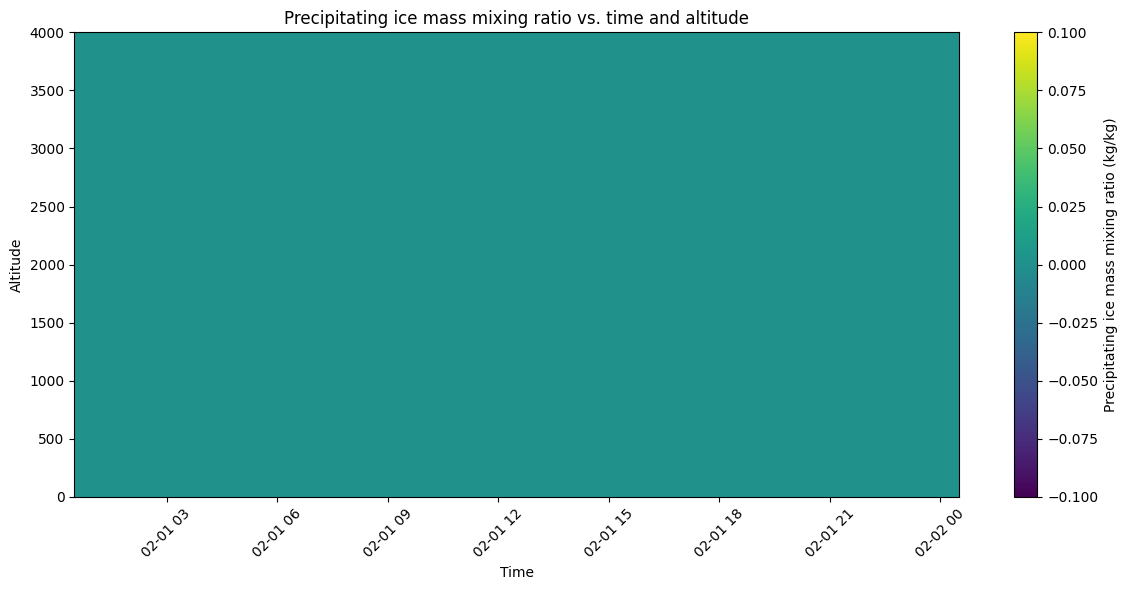

In [13]:
# Plot precipitating ice mass mixing ratio

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_qpi.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Precipitating ice mass mixing ratio (kg/kg)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Precipitating ice mass mixing ratio vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_qpi_20180219 = plt.gcf()
# ACCESS_qpi_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_qpi_20180219.png', dpi=200)
plt.show()

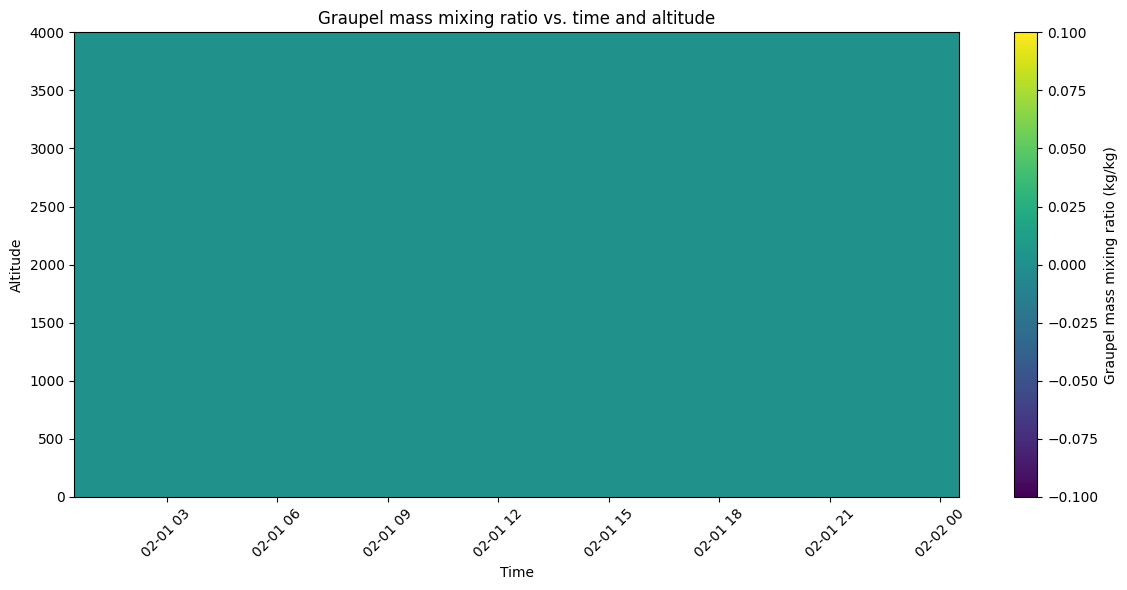

In [14]:
# Plot graupel mass mixing ratio

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_qpg.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Graupel mass mixing ratio (kg/kg)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Graupel mass mixing ratio vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_qpg_20180219 = plt.gcf()
# ACCESS_qpg_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_qpg_20180219.png', dpi=200)
plt.show()

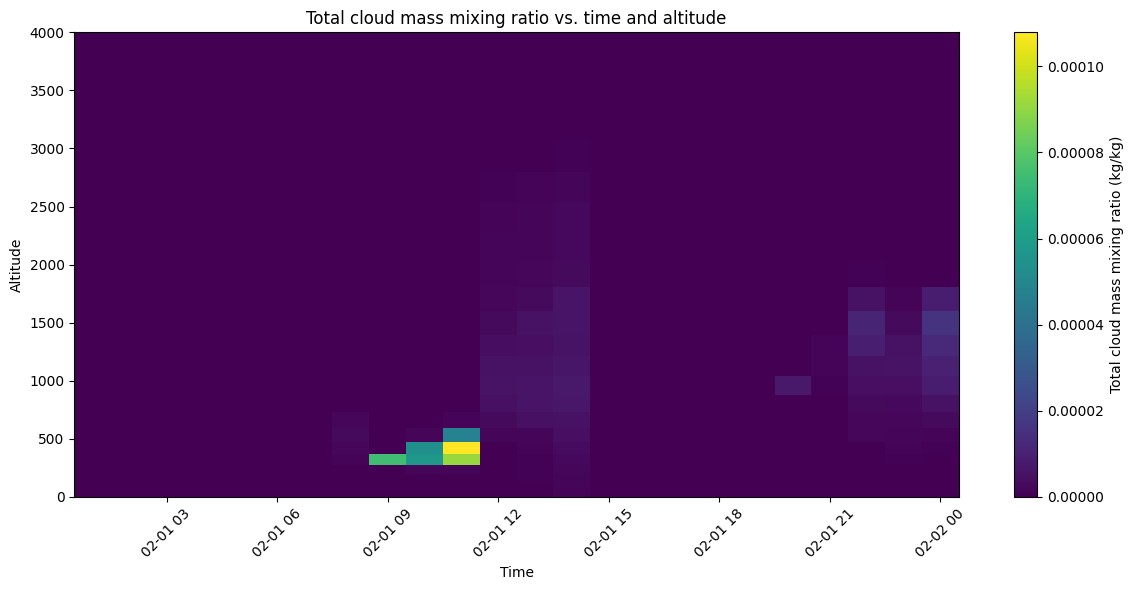

In [15]:
# Plot total cloud mass mixing ratio

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_qtot.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Total cloud mass mixing ratio (kg/kg)')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Total cloud mass mixing ratio vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_qtot_20180219 = plt.gcf()
# ACCESS_qtot_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_qtot_20180219.png', dpi=200)
plt.show()

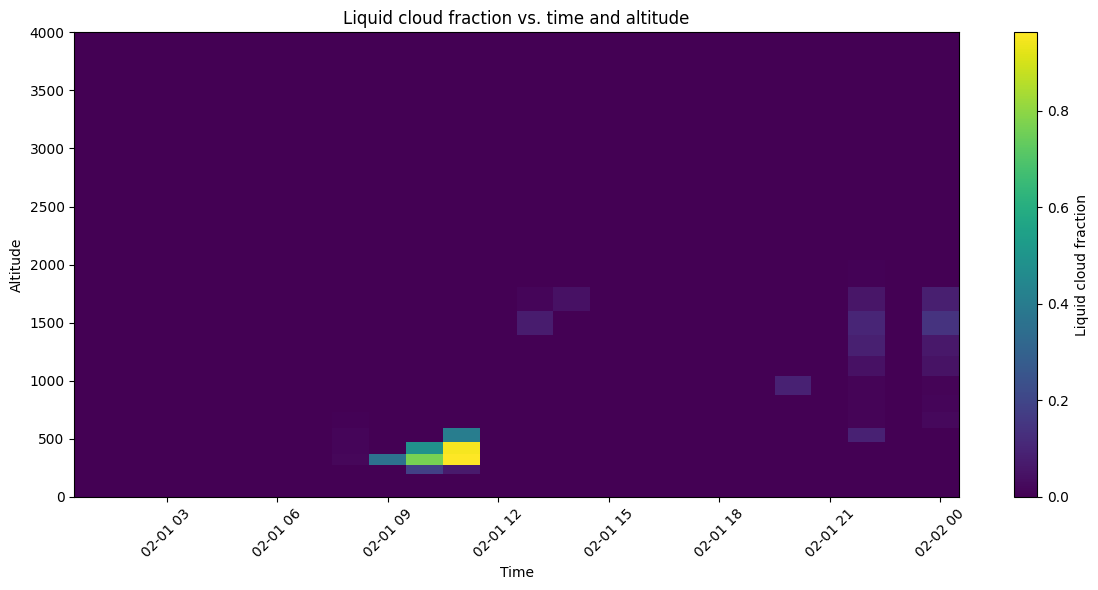

In [16]:
# Plot liquid cloud fraction data

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_liquid_cloud_fraction.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Liquid cloud fraction')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Liquid cloud fraction vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_lcf_20180219 = plt.gcf()
# ACCESS_lcf_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_lcf_20180219.png', dpi=200)
plt.show()

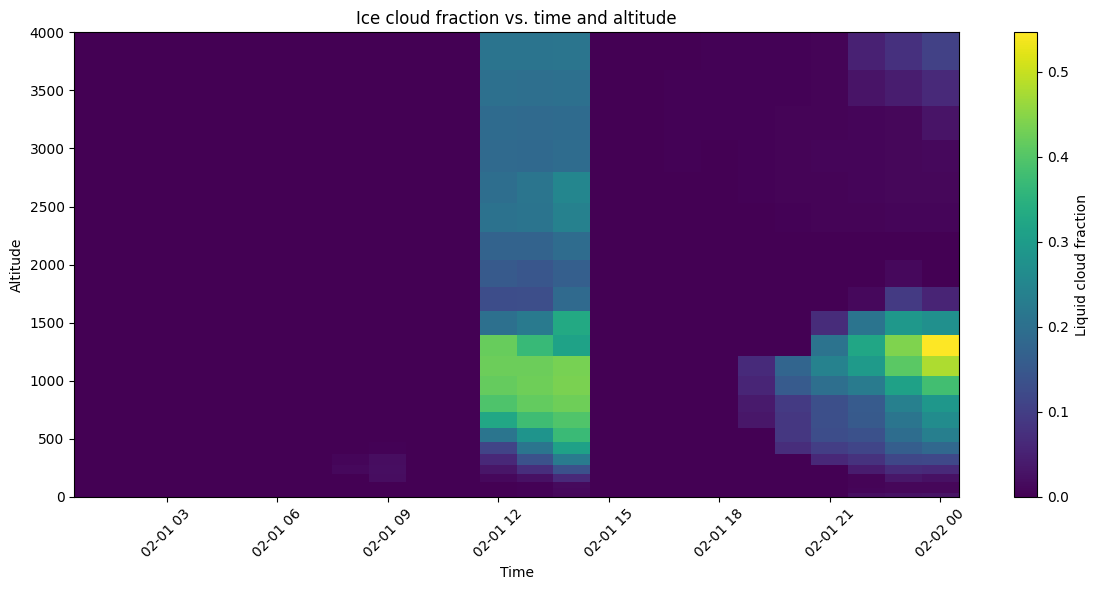

In [17]:
# Plot ice cloud fraction data

# Create a meshgrid for time and range
met_time_mesh, met_height_mesh = np.meshgrid(met_time, met_height)

# # Create the plot
plt.figure(figsize=(12, 6))

# # Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')

# # Create a pcolormesh plot
pcm = plt.pcolormesh(met_time_mesh, met_height_mesh, met_ice_cloud_fraction.T, cmap='viridis', shading='auto')

plt.colorbar(pcm, label='Liquid cloud fraction')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Ice cloud fraction vs. time and altitude')

plt.ylim(0,4000)
plt.xticks(rotation=45)
plt.tight_layout()
ACCESS_icf_20180219 = plt.gcf()
# ACCESS_icf_20180219.savefig('/g/data/jk72/ck4840/projects/emc2/figs/marcus/ACCESS_icf_20180219.png', dpi=200)
plt.show()